<a href="https://colab.research.google.com/github/cam2149/MachineLearningIV/blob/main/aa_iv_2025_i_object_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
#kagglehub.login()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [55]:
# prompt: Eliminar todo el contenido de la carpeta /content/kaggle

!rm -rf /content/kaggle/*


In [56]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

#aa_iv_2025_i_object_localization_path = kagglehub.competition_download('aa-iv-2025-i-object-localization')

#


In [57]:
!kaggle competitions download -c aa-iv-2025-i-object-localization
print('Data source import complete.')

aa-iv-2025-i-object-localization.zip: Skipping, found more recently modified local copy (use --force to force download)
Data source import complete.


In [58]:
# prompt: Descomprimir el archivo unzip aa-iv-2025-i-object-localization.zip dentro de una carperta llamada kaggle

!mkdir kaggle
!mkdir kaggle/working
!unzip aa-iv-2025-i-object-localization.zip -d kaggle

# prompt: Mover el contenido de /content/kaggle/images/images a /content/kaggle/images y eliminar la carpeta /content/kaggle/images/images

import shutil
import os

# Ruta de la carpeta origen
source_dir = "/content/kaggle/images/images"

# Ruta de la carpeta destino
destination_dir = "/content/kaggle/images"

# Verificar si la carpeta origen existe
if os.path.exists(source_dir):
  # Mover los archivos
  for filename in os.listdir(source_dir):
      source_file = os.path.join(source_dir, filename)
      destination_file = os.path.join(destination_dir, filename)

      if os.path.isfile(source_file):
          shutil.move(source_file, destination_file)

  # Eliminar la carpeta origen
  os.rmdir(source_dir)
  print(f"Los archivos de '{source_dir}' se movieron a '{destination_dir}' y la carpeta se eliminó.")
else:
  print(f"La carpeta '{source_dir}' no existe.")

mkdir: cannot create directory ‘kaggle’: File exists
Archive:  aa-iv-2025-i-object-localization.zip
  inflating: kaggle/images/images/image_00001.jpeg  
  inflating: kaggle/images/images/image_00002.jpeg  
  inflating: kaggle/images/images/image_00003.jpeg  
  inflating: kaggle/images/images/image_00004.jpeg  
  inflating: kaggle/images/images/image_00005.jpeg  
  inflating: kaggle/images/images/image_00007.jpeg  
  inflating: kaggle/images/images/image_00011.jpeg  
  inflating: kaggle/images/images/image_00012.jpeg  
  inflating: kaggle/images/images/image_00013.jpeg  
  inflating: kaggle/images/images/image_00014.jpeg  
  inflating: kaggle/images/images/image_00015.jpeg  
  inflating: kaggle/images/images/image_00016.jpeg  
  inflating: kaggle/images/images/image_00017.jpeg  
  inflating: kaggle/images/images/image_00018.jpeg  
  inflating: kaggle/images/images/image_00019.jpeg  
  inflating: kaggle/images/images/image_00020.jpeg  
  inflating: kaggle/images/images/image_00021.jpeg  

# Imports

Here we import the required libraries

In [59]:
!pip install torchsummary

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function, division

from tqdm import tqdm, tqdm_notebook
tqdm_notebook().pandas()


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy.typing import NDArray
from functools import reduce
from itertools import islice
import wandb
import math
from itertools import chain
import copy
from PIL import Image

import torch
from torch import nn
from torch import Tensor
from torch.optim import Optimizer
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchsummary import summary
# Import albumentations library in order to -use pre-built augmentations
import albumentations as A

from sklearn.model_selection import train_test_split
from multiprocessing import cpu_count

import os
import torch
import os.path as osp
from skimage import io, transform
import matplotlib.pyplot as plt
import typing as ty
import cv2


plt.ion()   # interactive mode

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for root, dirs, filenames in os.walk('/content/kaggle'):
    for i, filepath in enumerate(filenames):
        if i >= 10:
            print()
            break
        print(osp.join(root, filepath))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<ipython-input-60-362389544fe7>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm_notebook().pandas()


0it [00:00, ?it/s]

/content/kaggle/train.csv
/content/kaggle/test.csv
/content/kaggle/sample_submission.csv
/content/kaggle/images/image_00158.jpeg
/content/kaggle/images/image_00109.jpeg
/content/kaggle/images/image_00018.jpeg
/content/kaggle/images/image_00292.jpeg
/content/kaggle/images/image_00046.jpeg
/content/kaggle/images/image_00028.jpeg
/content/kaggle/images/image_00295.jpeg
/content/kaggle/images/image_00074.jpeg
/content/kaggle/images/image_00121.jpeg
/content/kaggle/images/image_00067.jpeg



## Creating dataset structure

In [61]:
torch.manual_seed(32)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')
test = torch.ones((100, 100)).to(device)
del test
torch.cuda.empty_cache()

Using cpu


This is done in order to control randomness.

In [62]:
DATA_DIR = '/content/kaggle'
WORK_DIR = '/content/kaggle/working'
BATCH_SIZE = 32
img_dir = osp.join(DATA_DIR, "images/")
train_file = osp.join(DATA_DIR, "train.csv")
obj2id  = {'f16':0,'cougar':1,'chinook':2,'ah64':3,'f15':4,'seahawk':5}
id2obj  = {0:'f16',1:'cougar',2:'chinook',3:'ah64',4:'f15',5:'seahawk'}
columns_f=['filename','xmin','ymin','xmax','ymax','class','class_id']

In [63]:
df = pd.read_csv(train_file)
df["class_id"] = df["class"].map(obj2id)
df= df[columns_f].copy()

In [64]:
img_filename = osp.join(img_dir,'image_00077.jpeg')

#Esta línea lee el archivo de imagen usando la función cv2.imread de la biblioteca OpenCV (cv2).
#Los datos de la imagen se cargan en la variable img1 como un array NumPy. OpenCV, por defecto, carga las imágenes en formato de color BGR (Azul, Verde, Rojo).
img1 = cv2.imread(img_filename)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

print(f"Los datos de img1 '{img_filename}' usando OpenCV (cv2).")
print(img1.shape)
print(img1.transpose((2,0,1)).shape)

# lee el mismo archivo de imagen, pero esta vez usando io.imread de la biblioteca scikit-image (skimage.io).
img2 = io.imread(img_filename) # no necesita bgr2rgb
print(f"Los datos de img2 '{img_filename}' usando io.imread de la biblioteca scikit-image (skimage.io).")
print(img2.shape)
print(img2.transpose((2,0,1)).shape)



Los datos de img1 '/content/kaggle/images/image_00077.jpeg' usando OpenCV (cv2).
(720, 1280, 3)
(3, 720, 1280)
Los datos de img2 '/content/kaggle/images/image_00077.jpeg' usando io.imread de la biblioteca scikit-image (skimage.io).
(720, 1280, 3)
(3, 720, 1280)


In [65]:
#Se crean cuatro listas vacías para almacenar:
#data_shape: la forma de cada imagen (ej. (720, 1280, 3) para una imagen de 720 píxeles de alto, 1280 de ancho y 3 canales de color).
#data_dim: el número de dimensiones de cada imagen (ej. 3 para una imagen en color).
#data_w: el ancho de cada imagen.
#data_h: el alto de cada imagen.

list_image = list(df.filename)
data_shape = []
data_dim = []
data_w = []
data_h = []

#Este bucle itera sobre cada nombre de archivo en la lista list_image. tqdm es una librería que muestra una barra de progreso para visualizar el avance del bucle

for i in tqdm(list_image): ## tqdm(list_image)dura 40 segundos
    ruta_imagen = osp.join(img_dir, i)
    imagen = io.imread(ruta_imagen)
    shapes = imagen.shape
    dimen = imagen.ndim
    imagen = Image.open(ruta_imagen)
    w, h = imagen.size
    data_w.append(w)
    data_h.append(h)
    data_shape.append(shapes)
    data_dim.append(dimen)

#Se crea un DataFrame de Pandas llamado data_w_h que contiene toda la información recopilada: nombre de archivo, forma, número de dimensiones, ancho y alto. .T transpone el DataFrame (cambia filas por columnas) y rename asigna nombres más descriptivos a las columnas.

data_w_h = pd.DataFrame([list_image,data_shape,data_dim,data_w,data_h]).T.rename(columns={0:'filename',1:'shapes',2:'ndim',3:'w',4:'h'})


100%|██████████| 189/189 [00:02<00:00, 85.80it/s] 


In [66]:
#data_w_h['w'].value_counts()
print(data_w_h['w'].value_counts().to_string())
#data_w_h['ndim'].value_counts()
print(data_w_h['ndim'].value_counts().to_string())
#df['class_id'].value_counts()
print(df['class_id'].value_counts().to_string())
#df['class'].value_counts()
print(df['class'].value_counts().to_string())

w
1280    189
ndim
3    189
class_id
0    41
1    37
2    35
3    34
4    23
5    19
class
f16        41
cougar     37
chinook    35
ah64       34
f15        23
seahawk    19


In [67]:
# Se busca encontrar y contar las inconsistencias en las coordenadas de los bounding boxes en el DataFrame df. Se espera que la forma del DataFrame resultante sea (0, n), donde n es el número de columnas, si no hay inconsistencias. Si la forma tiene un número de filas mayor que 0, significa que hay bounding boxes con coordenadas inconsistentes que necesitan ser revisadas o corregidas

df[df['xmin']>=df['xmax']].shape, df[df['ymin']>=df['ymax']].shape

((0, 7), (0, 7))

#Normalizamos los bboxes
Se realiza la normalización de las coordenadas de las cajas delimitadoras (bounding boxes) almacenadas en el DataFrame df.

**¿Qué son las cajas delimitadoras (bounding boxes)?**
Las cajas delimitadoras son rectángulos utilizados para definir la ubicación de un objeto en una imagen. Generalmente se representan mediante cuatro coordenadas:

xmin: La coordenada x de la esquina superior izquierda de la caja.
ymin: La coordenada y de la esquina superior izquierda de la caja.
xmax: La coordenada x de la esquina inferior derecha de la caja.
ymax: La coordenada y de la esquina inferior derecha de la caja.

**¿Qué es la normalización?**
La normalización es un proceso de escalar datos a un rango específico, típicamente entre 0 y 1. A menudo se utiliza para mejorar el rendimiento de los modelos de aprendizaje automático.

In [68]:
h_real=720
w_real=1280
h, w, c = 255, 400, 3 # The heigh, width and number of channels of each image

In [69]:
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin         xmax
count  189.000000  189.000000  189.000000   189.000000
mean   186.396825  425.455026  401.238095   902.666667
std    112.079883  103.348946  232.361996   213.588688
min      1.000000  154.000000    1.000000   298.000000
25%    109.000000  359.000000  210.000000   730.000000
50%    188.000000  417.000000  418.000000   901.000000
75%    267.000000  494.000000  572.000000  1071.000000
max    440.000000  702.000000  944.000000  1280.000000


In [70]:
# Normalizar las columnas ymin, ymax, xmin, xmax
df[["ymin", "ymax"]] = df[["ymin", "ymax"]].div(h_real, axis=0)
df[["xmin", "xmax"]] = df[["xmin", "xmax"]].div(w_real, axis=0)


In [71]:
print(df[["ymin", "ymax", "xmin", "xmax"]].describe())

             ymin        ymax        xmin        xmax
count  189.000000  189.000000  189.000000  189.000000
mean     0.258884    0.590910    0.313467    0.705208
std      0.155667    0.143540    0.181533    0.166866
min      0.001389    0.213889    0.000781    0.232813
25%      0.151389    0.498611    0.164062    0.570312
50%      0.261111    0.579167    0.326562    0.703906
75%      0.370833    0.686111    0.446875    0.836719
max      0.611111    0.975000    0.737500    1.000000


In [72]:
#Esta sección divide el conjunto de datos en dos subconjuntos: uno para entrenar el modelo de aprendizaje automático (train_df) y otro para validar su rendimiento (val_df).
#Se utiliza la función train_test_split de la biblioteca sklearn.model_selection. Esta función está específicamente diseñada para dividir conjuntos de datos en subconjuntos de entrenamiento y prueba (o validación). En este caso, el 25% de los datos se utilizará para la validación y el 75% restante se utilizará para el entrenamiento.

train_df, val_df = train_test_split(
    df, stratify=df['class_id'], test_size=0.25, random_state=42
)

print(train_df.shape)
print(val_df.shape)


(141, 7)
(48, 7)


In [73]:
classes = df["class"].unique()
classes

array(['cougar', 'seahawk', 'ah64', 'f16', 'f15', 'chinook'], dtype=object)

El conjunto de entrenamiento contiene información sobre la clase de cada imagen y la caja delimitadora correspondiente


In [74]:
#Muestra la distribución porcentual de cada clase o categoría dentro de tu conjunto de datos de entrenamiento (train_df)
train_df['class'].value_counts(1) * 100

,proportion
class,
f16,21.985816
cougar,19.858156
chinook,18.439716
ah64,17.730496
f15,12.056738
seahawk,9.929078


In [75]:
#Muestra la distribución porcentual de cada clase o categoría dentro de tu conjunto de datos de entrenamiento (val_df)
val_df['class'].value_counts(1) * 100

,proportion
class,
f16,20.833333
chinook,18.750000
cougar,18.750000
ah64,18.750000
f15,12.500000
seahawk,10.416667


Pero el conjunto de prueba solo contiene el nombre del archivo de cada imagen, por lo que tenemos que generar predicciones y enviarlas a la competencia de Kaggle.

In [76]:
#La clase militarDataset proporciona una forma de cargar y preprocesar imágenes y etiquetas para un modelo de aprendizaje automático. Permite aplicar transformaciones a las imágenes, redimensionarlas y acceder a elementos individuales del conjunto de datos mediante su índice. Está diseñada para ser utilizada con el framework PyTorch para el entrenamiento de modelos de visión por computadora

transform_func_inp_signature = ty.Dict[str, NDArray[np.float_]]
transform_func_signature = ty.Callable[
    [transform_func_inp_signature],
    transform_func_inp_signature
]

class militarDataset(Dataset):
    """
    Location image dataset
    """
    def __init__(
        self,
        df: pd.DataFrame,
        root_dir: str,
        labeled: bool = True,
        transform: ty.Optional[ty.List[transform_func_signature]] = None,
        output_size: ty.Optional[tuple] = None  # Añadir parámetro para tamaño de salida
    ) -> None:
        self.df = df
        self.root_dir = root_dir
        self.transform = transform
        self.labeled = labeled
        self.output_size = output_size  # Almacenar el tamaño de salida

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx: int) -> transform_func_signature:
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Read image
        img_name = os.path.join(self.root_dir, self.df.filename.iloc[idx])
        #img_name = os.path.join(self.root_dir, self.df.iloc[idx]['filename'])
        image = io.imread(img_name)
        #image = cv2.imread(img_name)


        #print(f"Dimensiones originales de la imagen: {image.shape}")  # Agregar para depuración
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_name}")

        if image.ndim == 2:  # Si la imagen está en escala de grises
            image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)  # Convertir a RGB
        elif image.shape[2] == 4:  # Si la imagen es RGBA
            image = image[:, :, :3]

        # Redimensionar la imagen si se especifica un tamaño de salida
        if self.output_size:
            image = cv2.resize(image, self.output_size)  # Redimensionar la imagen

        sample = {'image': image}

        if self.labeled:
            # Read labels
            img_class = self.df.class_id.iloc[idx]
            img_bbox = self.df.iloc[idx, 1:5]

            img_bbox = np.array([img_bbox]).astype('float')
            img_class = np.array([img_class]).astype('int')
            sample.update({'bbox': img_bbox, 'class_id': img_class})

        if self.transform:
            sample = self.transform(sample)

        return sample


In [77]:
#Este fragmento de código define una serie de funciones que tienen como objetivo principal dibujar cajas delimitadoras (bounding boxes) y etiquetas de clase en imágenes. Esto es muy común en tareas de visión por computadora, especialmente en la detección de objetos, donde se necesita visualizar las predicciones del modelo sobre las imágenes.

#Esta función dibuja una sola caja delimitadora en una imagen.
def draw_bbox(img, bbox, color,thickness: int = 3):
    xmin, ymin, xmax, ymax = bbox
    img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, thickness)
    return img

#Convierte las coordenadas de una caja delimitadora normalizadas (entre 0 y 1) a coordenadas en píxeles, usando el alto (h) y ancho (w) de la imagen.
def normalize_bbox(bbox, h: int, w: int):
    """Escala las coordenadas normalizadas al tamaño real de la imagen."""
    return [
        int(bbox[0] * w),  # xmin
        int(bbox[1] * h),  # ymin
        int(bbox[2] * w),  # xmax
        int(bbox[3] * h),  # ymax
    ]

#Dibuja múltiples cajas delimitadoras en una lista de imágenes.
def draw_bboxes(imgs, bboxes, colors,thickness):
    """Dibuja múltiples cuadros delimitadores en imágenes, escalando según h y w."""
    for i, (img, bbox, color) in enumerate(zip(imgs, bboxes, colors)):
        imgs[i] = draw_bbox(img, bbox, color,thickness)
    return imgs

# Escribe las etiquetas de clase en las imágenes.
def draw_classes(imgs, classes, colors, origin, prefix: str ='',fontScale : int = 2):
    """Dibuja las clases en las imágenes."""
    for i, (img, class_id, color) in enumerate(zip(imgs, classes, colors)):
        if type(c)==list:
            name_class_=id2obj[classes[i]]
        else:
            name_class_=id2obj[classes[i][0]]
        imgs[i] = cv2.putText(
            img, f'{prefix}{name_class_}', #class_id.squeeze()
            origin, cv2.FONT_HERSHEY_SIMPLEX,
            fontScale , color, 2, cv2.LINE_AA
        )
    return imgs

#Esta es la función principal que combina las funciones anteriores para dibujar las predicciones del modelo (cajas delimitadoras y etiquetas de clase) en las imágenes.
def draw_predictions(imgs, classes, bboxes, colors, origin,thickness,fontScale):
    """
    Combina las funciones anteriores para dibujar cuadros delimitadores
    y clases en las imágenes.
    """
    assert all(len(x) > 0 for x in [imgs, classes, bboxes, colors])
    if len(colors) == 1:
        colors = [colors[0] for _ in imgs]
    imgs = draw_bboxes(imgs, bboxes, colors,thickness)
    imgs = draw_classes(imgs, classes, colors, origin,"",fontScale)
    return imgs

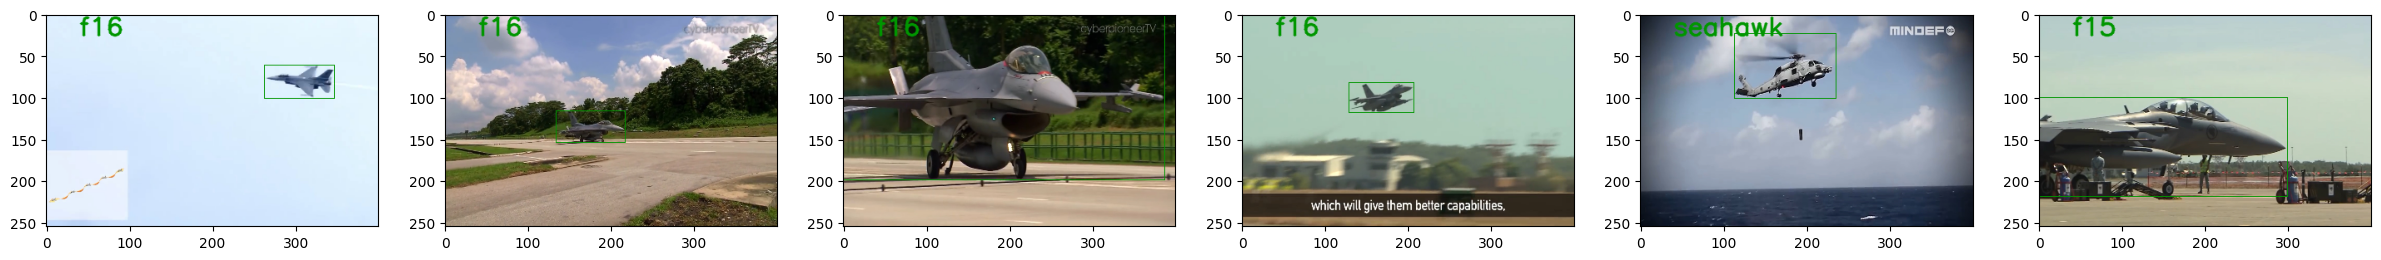

In [81]:
#Este fragmento de código es responsable de visualizar algunas imágenes de muestra del conjunto de datos de entrenamiento junto con sus cuadros delimitadores y etiquetas de clase. Es una forma de verificar visualmente que el proceso de carga de datos y anotación esté funcionando correctamente.

train_root_dir = osp.join(DATA_DIR, "images")#, "train"
train_ds = militarDataset(train_df, root_dir=train_root_dir,output_size=(w,h))

#num_imgs: Esta variable especifica el número de imágenes a visualizar (6 en este caso).
#start_idx: Esta variable determina el índice de inicio de las imágenes a visualizar (0 en este caso, lo que significa que comienza desde la primera imagen).
num_imgs = 6
start_idx = 0 #Siempre valor 0

#samples: Se crea una lista obteniendo num_imgs muestras del conjunto de datos train_ds, comenzando desde start_idx. Cada muestra es un diccionario que contiene la imagen, el cuadro delimitador y el ID de clase.

samples = [train_ds[i] for i in range(start_idx, num_imgs)]

#imgs: Se extrae una lista de imágenes de la lista samples.
#bboxes: Se extrae una lista de cuadros delimitadores y cada cuadro delimitador se normaliza utilizando la función normalize_bbox para convertirlo de coordenadas relativas (entre 0 y 1) a coordenadas de píxeles según la altura (h) y el ancho (w) de la imagen.
#classes: Se extrae una lista de ID de clase de la lista samples

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze(),h,w) for s in samples]
classes = [s['class_id'] for s in samples]

#draw_predictions: Se llama a esta función para dibujar los cuadros delimitadores y las etiquetas de clase en las imágenes. Toma las imágenes (imgs), las clases (classes), los cuadros delimitadores (bboxes), el color para las anotaciones ((0, 150, 0) que es verde), las coordenadas de origen para el texto de la etiqueta de clase ((int(w*0.1), int(h*0.1))), el grosor de las líneas del cuadro delimitador y la escala de fuente para las etiquetas de clase como entrada.

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (int(w*0.1), int(h*0.1)),thickness = 1,fontScale=1)#(150, 10)

#Esta parte del código crea una figura de Matplotlib y subplots para mostrar las imágenes anotadas. Itera a través de la lista imgs y muestra cada imagen usando plt.imshow. Finalmente, se llama a plt.show() para renderizar la figura.
fig = plt.figure(figsize=(30, num_imgs))

for i, img in enumerate(imgs):
    fig.add_subplot(1, num_imgs, i+1)
    plt.imshow(img)

plt.show()

In [82]:
samples[0]['bbox']

array([[0.65703125, 0.24166667, 0.8671875 , 0.39861111]])

In [83]:
samples[0]['class_id']

array([0])

# Transfer learning


En nuestro caso, estamos interesados en obtener un modelo preentrenado para utilizarlo como columna vertebral (backbone) que ha sido entrenado en otras tareas. Por ejemplo, si queremos usar VGG16 como nuestra columna vertebral, no necesitaríamos el último módulo de clasificación y mantendríamos el módulo de agrupación promedio (averaged pool) como fuente de características para realizar ambas

In [84]:
#El código define una clase en Python llamada FeatureExtractor. Esta clase está diseñada para extraer características de una imagen utilizando un modelo preentrenado (en este caso, VGG16).
#FeatureExtractor actúa como un filtro que procesa una imagen y extrae su información visual más esencial, lo que facilita que el resto del modelo aprenda y haga predicciones. Aprovecha el conocimiento obtenido de un modelo preentrenado, ahorrando tiempo y recursos en comparación con entrenar un modelo desde cero.

from torchvision.models import vgg16

class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        # Extract VGG-16 Feature Layers
        self.features = list(model.features)
        self.features = nn.Sequential(*self.features)
        # Extract VGG-16 Average Pooling Layer
        self.pooling = model.avgpool
        # Convert the image into one-dimensional vector
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # It will take the input 'x' until it returns the feature vector called 'out'
        out = self.features(x)
        out = self.pooling(out)
        out = self.flatten(out)
        out = self.dropout(out)
        return out

# Load the vgg16 model
vgg16_model = vgg16(pretrained=True, progress=True)
pretrained_model = FeatureExtractor(vgg16_model).to(device)
pretrained_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:08<00:00, 68.4MB/s]


FeatureExtractor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [85]:
summary(pretrained_model, (3, 720, 1280))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 720, 1280]           1,792
              ReLU-2        [-1, 64, 720, 1280]               0
            Conv2d-3        [-1, 64, 720, 1280]          36,928
              ReLU-4        [-1, 64, 720, 1280]               0
         MaxPool2d-5         [-1, 64, 360, 640]               0
            Conv2d-6        [-1, 128, 360, 640]          73,856
              ReLU-7        [-1, 128, 360, 640]               0
            Conv2d-8        [-1, 128, 360, 640]         147,584
              ReLU-9        [-1, 128, 360, 640]               0
        MaxPool2d-10        [-1, 128, 180, 320]               0
           Conv2d-11        [-1, 256, 180, 320]         295,168
             ReLU-12        [-1, 256, 180, 320]               0
           Conv2d-13        [-1, 256, 180, 320]         590,080
             ReLU-14        [-1, 256, 1

In [86]:
vgg16_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# Image normalization

In [87]:
train_df.shape

(141, 7)

In [ ]:
train_ds = militarDataset(train_df, root_dir=train_root_dir,output_size=(255,255))#,output_size=(255,255)

means = np.zeros(3)
stds = np.zeros(3)
n_images = 0

for x in train_ds:
    img = x['image']#.astype(np.float32)  # Asegúrate de que la imagen está en float para cálculos precisos
    n_images += 1

    for channel in range(3):
        channel_pixels = img[..., channel]
        # Acumular la suma y suma de cuadrados para calcular la media y desviación estándar
        means[channel] += np.mean(channel_pixels)
        stds[channel] += np.std(channel_pixels)

# Calcular la media y desviación estándar final
means /= n_images
stds /= n_images

In [ ]:
print(means)
print(stds)

In [ ]:
print(means)
print(stds)

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Gioconda_%28copia_del_Museo_del_Prado_restaurada%29.jpg/800px-Gioconda_%28copia_del_Museo_del_Prado_restaurada%29.jpg

In [ ]:
img_filename = "800px-Gioconda_(copia_del_Museo_del_Prado_restaurada).jpg"
monalisa = cv2.imread(img_filename)
monalisa = cv2.cvtColor(monalisa, cv2.COLOR_BGR2RGB)

print(monalisa.shape)
monalisa[..., 0] = 0
#monalisa[..., 1] = 0
monalisa[..., 2] = 0

plt.imshow(monalisa)

In [ ]:
img_filename = osp.join(DATA_DIR, "images/images",'image_00007.jpeg')
img1 = cv2.imread(img_filename)
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

print(img1.shape)
print(img1.transpose((2,0,1)).shape)
img1[..., 0] = 0
img1[..., 1] = 0

plt.imshow(img1)

# Image transforms

A recommended library to do image augmentation is https://albumentations.ai/docs/examples/pytorch_classification/


In [ ]:

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C (0,1,2)
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image).float()
        sample.update({'image': image})
        return sample


class Normalizer(object):

    def __init__(self, stds, means):
        """
        Arguments:

            stds: array of length 3 containing the standard deviation of each channel in RGB order.
            means: array of length 3 containing the means of each channel in RGB order.
        """
        self.stds = stds
        self.means = means

    def __call__(self, sample):
        """
        Sample: a dicitonary containing:
            image: sample image in format (C, H, W)
        Returns:
            the image in (C, H, W) format with the channels normalized.
        """
        image = sample['image']

        for channel in range(3):
            image[channel] = (image[channel] - means[channel]) / stds[channel]

        sample['image'] = image
        return sample

class TVTransformWrapper(object):
    """Torch Vision Transform Wrapper
    """
    def __init__(self, transform: torch.nn.Module):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample

class AlbumentationsWrapper(object):

    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        transformed = self.transform(
            image=sample['image'],
            bboxes=sample['bbox'],
            #category_ids=sample['class_id']
        )
        sample['image'] = transformed['image']
        sample['bbox'] = np.array(transformed['bboxes'])
        return sample



In [ ]:
common_transforms = [
    ToTensor(),
    Normalizer(
        means=means,
        stds=stds,
    )
]

train_data_augmentations = A.Compose([
    A.HorizontalFlip(p=1),
    ],
    bbox_params=A.BboxParams(
        format='albumentations',
        label_fields=[],
    )
)

train_transforms = torchvision.transforms.Compose(
    [
        AlbumentationsWrapper(train_data_augmentations),
    ] + common_transforms
)

eval_transforms = torchvision.transforms.Compose(common_transforms)

In [ ]:
train_ds = militarDataset(train_df, root_dir=train_root_dir,output_size=(255,255))

x = next(iter(train_ds))
x_transformed = copy.deepcopy(x)
x_transformed = train_transforms(x_transformed)

original_img = x['image']
transformed_img = x_transformed['image'].numpy().transpose(1, 2, 0)
transformed_img = cv2.resize(transformed_img, (255,255)) ## Redimensiona la imagen

original_img = draw_bbox(
    original_img,
    normalize_bbox(x['bbox'].squeeze(),h,w),
    (0, 255, 0),thickness=1
)

transformed_img = draw_bbox(
    transformed_img,
    normalize_bbox(x_transformed['bbox'].squeeze(),h,w),
    (0, 255, 0),thickness=1
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(original_img)
axes[0].set_title('Original digit')

axes[1].imshow(transformed_img)
axes[1].set_title('Transformed digit')

plt.show()

In [ ]:
train_ds = militarDataset(df, root_dir=train_root_dir, transform=train_transforms,output_size=(255,255))#
train_data = torch.utils.data.DataLoader(train_ds, batch_size=16)#,collate_fn=custom_collate_fn

for x in train_data:
    print(x['image'].size())
    break

In [ ]:
def get_output_shape(model: nn.Sequential, image_dim: ty.Tuple[int, int, int]):
    return model(torch.rand(*(image_dim)).to(device)).data.shape

class Model(nn.Module):
    def __init__(self, input_shape: ty.Tuple[int, int, int] = (3, 255, 400), n_classes: int = 6):
        """
        Model with one input (image) and two outputs:
            1. Digit classification (classification).
            2. Bounding box prediction (regression).

        Arguments:
            input_shape: input shape of the image in format (C, H, W)
            n_classes: number of classes to perfrom classification with

        Attributes:
            backbone: ConvNet that process the image and
            returns a flattened vector with the information of the
            activations.

            cls_head: MLP that receives the flattened input from the backbone
            and predicts the classification logits for the classes (classficiation task).

            reg_head: MLP that receives the flattened input from the backbone
            and predicts the coordinates of the predicted bounding box (regression task).
        """
        super().__init__()

        self.input_shape = input_shape

        # When doing transfer learning, use pretrained model instead of custom backbone
        self.backbone = pretrained_model

        backbone_output_shape = get_output_shape(self.backbone, [1, *input_shape])
        backbone_output_features = reduce(lambda x, y: x*y, backbone_output_shape)

        self.cls_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )

        self.reg_head = nn.Sequential(
            nn.Linear(in_features=backbone_output_features, out_features=768),
            nn.ReLU(),
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 4)
        )

    def forward(self, x: Tensor) -> ty.Dict[str, Tensor]:
        features = self.backbone(x)
        cls_logits = self.cls_head(features)
        pred_bbox = self.reg_head(features)
        predictions = {'bbox': pred_bbox, 'class_id': cls_logits}
        return predictions

In [ ]:
#torch.cuda.empty_cache()
import gc
torch.cuda.empty_cache()
gc.collect()

In [ ]:
print('image', x['image'].size())
model = Model(input_shape=(3, h, w), n_classes=6).to(device)
x['image'] = x['image'].to(device)
preds = model(x['image'])
preds

# Metrics

In [ ]:
def iou(y_true: Tensor, y_pred: Tensor):
    pairwise_iou = torchvision.ops.box_iou(y_true.squeeze(), y_pred.squeeze())
    result = torch.trace(pairwise_iou) / pairwise_iou.size()[0]
    return result

In [ ]:
def accuracy(y_true: Tensor, y_pred: Tensor):
    pred = torch.argmax(y_pred, axis=-1)
    y_true = y_true.squeeze()
    correct = torch.eq(pred, y_true).float()
    total = torch.ones_like(correct)
    result = torch.divide(torch.sum(correct), torch.sum(total))
    return result

# Loss fn

In [ ]:
def loss_fn(y_true, y_preds, alpha: float = 0.5):
    cls_y_true, cls_y_pred = y_true['class_id'].long(), y_preds['class_id'].float().unsqueeze(-1)
    reg_y_true, reg_y_pred = y_true['bbox'].float().squeeze(), y_preds['bbox'].float().squeeze()

    cls_loss = F.cross_entropy(cls_y_pred, cls_y_true)

    reg_loss = F.mse_loss(reg_y_pred, reg_y_true)
    # Adds weights to both tasks
    total_loss = (1 - alpha) * cls_loss + alpha * reg_loss
    return dict(loss=total_loss, reg_loss=reg_loss,cls_loss=cls_loss)

# Callbacks

In [ ]:
def printer(logs: ty.Dict[str, ty.Any]):
    # print every 10 steps
    if logs['iters'] % 10 != 0:
        return
    print('Iteration #: ',logs['iters'])
    for name, value in logs.items():
        if name == 'iters':
            continue

        if type(value) in [float, int]:
            value = round(value, 4)
        elif type(value) is torch.Tensor:
            value = torch.round(value, decimals=4)

        print(f'\t{name} = {value}')
    print()

# Training loop

In [ ]:
def evaluate(
    logs: ty.Dict[str, ty.Any],
    labels: ty.Dict[str, Tensor],
    preds: ty.Dict[str, Tensor],
    eval_set: str,
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    losses: ty.Optional[ty.Dict[str, Tensor]] = None,
) -> ty.Dict[str, ty.Any]:

    if losses is not None:
        for loss_name, loss_value in losses.items():
            logs[f'{eval_set}_{loss_name}'] = loss_value

    for task_name, label in labels.items():
        for metric_name, metric in metrics[task_name]:
            value = metric(label, preds[task_name])
            logs[f'{eval_set}_{metric_name}'] = value

    return logs

def step(
    model: Model,
    optimizer: Optimizer,
    batch: militarDataset,
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    device: str,
    train: bool = False,
) -> ty.Tuple[ty.Dict[str, Tensor], ty.Dict[str, Tensor]]:

    if train:
        optimizer.zero_grad()

    #img = batch['image'].to(device)
    img = batch.pop('image').to(device)

    for k in list(batch.keys()):
        batch[k] = batch[k].to(device)

    preds = model(img.float())
    losses = loss_fn(batch, preds)
    final_loss = losses['loss']

    if train:
        final_loss.backward()
        optimizer.step()

    return losses, preds


def train(
    model: Model,
    optimizer: Optimizer,
    dataset: DataLoader,
    eval_datasets: ty.List[ty.Tuple[str, DataLoader]],
    loss_fn: ty.Callable[[ty.Dict[str, torch.Tensor]], torch.Tensor],
    metrics: ty.Dict[str, ty.Callable[[Tensor, Tensor], Tensor]],
    callbacks: ty.List[ty.Callable[[ty.Dict[ty.Any, ty.Any]], None]],
    device: str,
    train_steps: 100,
    eval_steps: 10,
) -> Model:
    # Send model to device (GPU or CPU)
    model = model.to(device)
    iters = 0
    iterator = iter(dataset)
    assert train_steps > eval_steps, 'Train steps should be greater than the eval steps'

    while iters <= train_steps:
        logs = dict()
        logs['iters'] = iters
        try:
            batch = next(iterator)
        except StopIteration:
            iterator = iter(dataset)
            batch = next(iterator)
        # Send batch to device
        losses, preds = step(model, optimizer, batch, loss_fn, device, train=True)
        logs = evaluate(logs, batch, preds, 'train', metrics, losses)

        # Eval every eval_steps iterations
        if iters % eval_steps == 0:
            # Evaluate
            # Deactives layers that only needed to train
            # https://discuss.pytorch.org/t/model-eval-vs-with-torch-no-grad/19615
            model.eval()

            # Avoids calculating gradients in evaluation dataset.
            with torch.no_grad():

                for name, dataset in eval_datasets:

                    for batch in dataset:
                        losses, preds = step(model, optimizer, batch, loss_fn, device, train=False)
                        logs = evaluate(logs, batch, preds, name, metrics, losses)

        for callback in callbacks:
            callback(logs)

        iters += 1

    return model

# Run

In [ ]:
# Hparams
batch_size = 16
lr = 0.001

# Data
train_ds = militarDataset(train_df, root_dir=train_root_dir, transform=train_transforms,output_size=(255,255))#,output_size=(255,255)
val_ds = militarDataset(val_df, root_dir=train_root_dir, transform=eval_transforms,output_size=(255,255)) #,output_size=(255,255)

train_data = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=cpu_count())
val_data = DataLoader(val_ds, batch_size=batch_size, num_workers=cpu_count())

# Model
model = Model().to(device)
summary(model, model.input_shape)

In [ ]:
# Optimizer
optimizer = torch.optim.Adam(lr=lr, params=model.parameters())

model = train(
    model,
    optimizer,
    train_data,
    eval_datasets=[('val', val_data)],
    loss_fn=loss_fn,
    metrics={
        'bbox': [('iou', iou)],
        'class_id': [('accuracy', accuracy)]
    },
    callbacks=[printer],
    device=device,
    train_steps=100,
    eval_steps=10
)

In [ ]:
model.parameters()

In [ ]:
num_imgs = 5
ncols = 5
nrows = math.ceil(num_imgs / ncols)

start_idx = 0

inference_ds = militarDataset(val_df.iloc[start_idx:start_idx+num_imgs], root_dir=train_root_dir,output_size=(w,h))#,output_size=(255,255)
inference_data = DataLoader(inference_ds, batch_size=num_imgs, num_workers=1, shuffle=False)
inference_batch = next(iter(inference_data))
inference_imgs = np.empty((num_imgs, 3, h, w))

transform = eval_transforms

for i, img in enumerate(inference_batch['image']):
    inference_imgs[i] = transform(dict(image=img.numpy()))['image'].numpy()

preds = model(torch.tensor(inference_imgs).float().to(device))

samples = [inference_ds[i] for i in range(start_idx, num_imgs)]

imgs = [s['image'] for s in samples]
bboxes = [normalize_bbox(s['bbox'].squeeze(), h, w) for s in samples]
classes = [s['class_id'] for s in samples]

pred_bboxes = preds['bbox'].detach().cpu().numpy()
pred_bboxes = [normalize_bbox(bbox, h, w) for bbox in pred_bboxes]
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()

In [ ]:
# Green: ground truth

imgs = draw_predictions(imgs, classes, bboxes, [(0, 150, 0)], (int(w*0.1), int(h*0.1)),thickness = 1,fontScale=1)
# Red: predicted
pred_classes_ = []
for i in range(num_imgs):
    temp = np.array([pred_classes[i]])
    pred_classes_.append(temp)
imgs = draw_predictions(imgs, pred_classes_, pred_bboxes, [(200, 0, 0)], (int(w*0.8), int(h*0.8)),thickness = 1,fontScale=1)

fig, axes = plt.subplots(nrows=nrows, ncols=num_imgs // nrows, figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    ax.imshow(imgs[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
!wget https://m.media-amazon.com/images/I/51lHKrgInNL._AC_SL1000_.jpg
!ls


In [ ]:
pickle_rick_img = io.imread('51lHKrgInNL._AC_SL1000_.jpg')
pickle_rick_img = cv2.resize(pickle_rick_img, (w, h))
pickle_rick_img_=np.expand_dims(pickle_rick_img.transpose(2,0,1), 0)

In [ ]:
plt.imshow(pickle_rick_img)

In [ ]:
pickle_rick_img.shape, pickle_rick_img_.shape

In [ ]:
preds = model(torch.tensor(pickle_rick_img_).float().to(device))
pred_classes = preds['class_id'].argmax(-1).detach().cpu().numpy()
pred_bboxes = preds['bbox'].detach().cpu().numpy().tolist()
pred_class = id2obj[pred_classes[0]]
xmin=int(pred_bboxes[0][0]*w)
ymin=int(pred_bboxes[0][1]*h)
xmax=int(pred_bboxes[0][2]*w)
ymax=int(pred_bboxes[0][3]*h)
pickle_rick_img_ = cv2.rectangle(pickle_rick_img, (xmin, ymin), (xmax, ymax), (255, 0, 0))
pickle_rick_img_ = cv2.putText(pickle_rick_img_, pred_class, (xmin, ymin-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
plt.figure(figsize=(5, 5))
plt.imshow(pickle_rick_img_)
plt.axis("off")
plt.show()

In [ ]:
# Save the model to disk
torch.save(model, 'pretrained_model.pth')

# Submission

In [ ]:
# Perform inference on cpu in order to avoid memory problems
device = 'cuda'
model = model.to(device)

test_root_dir = osp.join(DATA_DIR, "images/images")
test_df = pd.read_csv(osp.join(DATA_DIR, "test.csv"))

test_ds = militarDataset(test_df, root_dir=test_root_dir, labeled=False, transform=eval_transforms,output_size=(w,h))#
test_data = DataLoader(test_ds, batch_size=1, num_workers=cpu_count(), shuffle=False)

class_preds = []
bbox_preds = []

for batch in test_data:
    batch_preds = model(batch['image'].float().to(device))

    class_pred = batch_preds['class_id'].argmax(-1).detach().cpu().numpy()
    bbox_pred = batch_preds['bbox'].detach().cpu().numpy()

    class_preds.append(class_pred.squeeze())
    bbox_preds.append(bbox_pred.squeeze())

In [ ]:
class_preds = np.array(class_preds)
bbox_preds = np.array(bbox_preds)

In [ ]:
submission = pd.DataFrame(
    index=test_df.filename,
    data={
        'class': class_preds,
        }
)
submission

In [ ]:
submission["xmin"] = bbox_preds[:, 0]*w_real
submission["ymin"] = bbox_preds[:, 1]*h_real
submission["xmax"] = bbox_preds[:, 2]*w_real
submission["ymax"] = bbox_preds[:, 3]*h_real

In [ ]:
submission['class']=submission['class'].replace(id2obj)

In [ ]:
submission['class'].value_counts()

In [ ]:
submission.to_csv('submission.csv')